In [23]:
import pickle
import torch.utils.data
import torch
from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

load_path = './data/acrobot/sw_cartpole1'

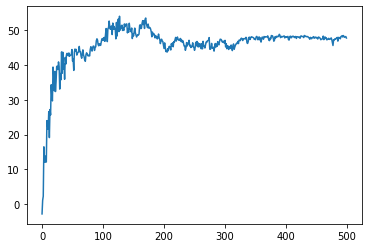

In [24]:
model, env, args, ws = load_workspace(load_path)
plt.plot(ws['avg_reward_hist'])

In [29]:
myenv = env
myenv.num_steps=1500

action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break
            
print(sum(reward_hist))

[0.00159393]


In [19]:
actions, _, _, _ = model.step(obs)
obs, reward, done, _ = env.step(actions)        
env.render()
print(reward)

-0.6896045784404392


In [16]:
env.state[0] = np.pi
env.state[1] = 1
env.render()

True

In [62]:
-(np.cos(env.state[0]) + np.cos(env.state[0] + env.state[1]))

2.0

In [42]:
np.cos(env.state[0])

0.9817307073878629

In [43]:
np.cos(env.state[1])

-0.8691494928152651

In [30]:
pprint(list(ws.keys()))

['gate_loss',
 'local_gate',
 'v_loss',
 'local_values',
 'p_loss',
 'r',
 'old_logp',
 'logp',
 'local_adv',
 'local_actions',
 'local_states',
 'training_generator',
 'training_data',
 'p_adv_tensor',
 'p_action_tensor',
 'p_state_tensor',
 'adv',
 'p_adv_list',
 'p_action_list',
 'p_state_list',
 'ep_adv',
 'deltas',
 'value_preds',
 'ep_gate_tensor',
 'ep_path_tensor',
 'ep_disc_rewards',
 'ep_action_tensor',
 'ep_state_tensor',
 'done',
 'reward',
 'state_np',
 'logprob',
 'action',
 'path',
 '_',
 'gate_out',
 't',
 'gate_list',
 'path_list',
 'reward_list',
 'state_list',
 'action_list',
 'state',
 'gate_tensor',
 'path_tensor',
 'action_tensor',
 'state_tensor',
 'disc_rewards_tensor',
 'adv_tensor',
 'traj_count',
 'traj_steps',
 'batch_steps',
 'episode_reward_sum',
 'epoch',
 'avg_reward_hist',
 'device',
 'use_cuda',
 'g_optimizer',
 'v_optimizer',
 'p_optimizer',
 'old_model',
 'num_states',
 'state_var',
 'state_mean',
 'gate_var_lookup',
 'action_var_lookup',
 'sched_len

In [31]:
ws['ep_path_tensor']

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [37]:
action_hist

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])